# Theory Calculation of Carbon Footprint

$$C_I = \eta^{-1} \left[ \frac{\langle r_{\leq \zeta l} \rangle}{\langle r \rangle} \, F_r(\zeta \ell) + 2\,\beta \frac{\ell}{\langle r \rangle} \, \bar F_r(\zeta \ell)\right] + 4 Q \varepsilon_0 \frac{\langle r \rangle}{\ell}\,,$$
$$Q=\frac{M}{R}=\frac{\mu}{\nu E \langle r\rangle^2}$$

## Imports, Constants, and Symbols

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import sympy
from IPython.display import display, Markdown
from ipywidgets import interact, interactive, FloatSlider, IntSlider

In [2]:
eps0 = 800/130
beta = 1/6*(np.sqrt(2)+np.log(1+np.sqrt(2)))
zeta = 2*beta

# Following only to have a realistic "guess" for Q
E = 8000 # per <r>^2
# E = 5e4/100 # per <r>^2
mean_distance = 1
mu = 10 # per day
# mu = 4
nu = 1 # per day
k=3.1
# nu = 1/9
Q = mu/(nu*E*mean_distance**2) # = M/R
Q = 0.008

A = mean_distance*2 # Upper constant for uniform Distr.
M = 2000
ell_min = 0.05
ell_max = 2 # For uniform Distr. it does not make sense to go further, otherwise system becomes unimodal
ell_list = np.linspace(ell_min,ell_max,M)

In [3]:
s_beta, s_eps0, s_ell, s_zeta, s_eta, s_Q = sympy.symbols(
    "β, ε0, ℓ, ζ, η, Q", real=True
)

In [4]:
print(Q)

0.008


In [5]:
# For treating Q as a dependend parameter
def Q_func(mu):
    return mu/(nu*E*mean_distance**2)

## Define probability distributions

In [6]:
def inverseGammaDistUnnormalized(x, k=3.1):
    return (x**(-k))*np.exp(-(k-2)*mean_distance/x)
    
def inverseGammaDistCummulative(r, k=3.1):
    return scipy.special.gammainc(k-1, (k-2)/r)
    
def uniformDist(x):
    if x>A:
        return 0
    elif x>0:
        return 1/A

def uniformDistCummulative(x):
    if x>A:
        return 1
    elif x>0:
        return x/A
    
    
normalization_uniform, _ = scipy.integrate.quad(uniformDist,0,np.infty)
assert np.isclose(1, normalization_uniform), "Should already be normalized"
normalization_inverse_gamma_numerical = 1/scipy.integrate.quad(inverseGammaDistUnnormalized,0,np.infty)[0]
normalization_inverse_gamma_analytical = (k-2)**(k-1)/scipy.special.gamma(k-1)

print("Normalization factor for Uniform distribution: ", normalization_uniform)
print("Normalization factor for InverseGamma distribution: ", normalization_inverse_gamma_numerical, "({})".format(normalization_inverse_gamma_analytical))

def inverseGammaDist(x):
    return inverseGammaDistUnnormalized(x)*normalization_inverse_gamma_analytical

def inverseGammaDistPrime(r, k=3.1):
    return r**(-k-1)*np.exp(-mean_distance*(k-2)/r)*(-k+mean_distance*(k-2)/r)*normalization_inverse_gamma_analytical

Normalization factor for Uniform distribution:  0.9999999999999855
Normalization factor for InverseGamma distribution:  1.1673236373431044 (1.167323637326722)


## Choose Probability Distribution and plot it

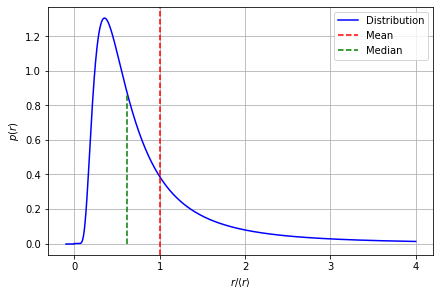

In [7]:
%matplotlib inline

# Either "uniformDist" or "inverseGammaDist"
probabilityDist = inverseGammaDist
probabilityDistCummulative = inverseGammaDistCummulative if probabilityDist == inverseGammaDist else uniformDistCummulative

fig, ax = plt.subplots(constrained_layout=True)

x = np.linspace(0.001,4*mean_distance,1000)
probabilities = np.vectorize(probabilityDist)(x)
ax.plot(x, probabilities, label='Distribution', c='b')
# ax.plot(x, np.vectorize(inverseGammaDistPrime)(x), ls='--')
# ax.plot(x, np.gradient(probabilities, x), ls='--')
ax.plot([-0.1,0,x[0]], [0,0,probabilities[0]], c='b')
ax.axvline(mean_distance, ls='--', c='r', label='Mean')
# ax.axvline(x[np.argmax(probabilities)], ls='--', c='g', label='Mode')
# ax.axvline((k-2)/k, ls='--', c='g', label='Mode') # Mode = beta/(alpha+1)
median = scipy.optimize.newton(lambda r: probabilityDistCummulative(r) - 0.5, x0=1)
# ax.axvline(median, ymin=0, ymax=0.2, ls='--', c='g', label='Median')
ax.plot([median, median], [0,probabilityDist(median)], ls='--', c='g', label='Median')
ax.grid()
ax.set_xlabel(r"$r/\langle r\rangle$")
ax.set_ylabel(r"$p(r)$")
ax.legend()

# fig.savefig("Uniform.jpg", dpi=200)
plt.show()

## Calculate Carbon Footprint

In [8]:
def delta_av_theory(delta_max, b, mode='mft'):
    delta_max = 1.5
    delta_bar = 2 * delta_max / 3 + 1 / (3 * delta_max)
    if mode=='mft':
        return np.exp(np.log(delta_bar) / np.log(2) * np.log((2*b - 1)))
    elif mode=='bimodal_test':
        return np.exp(np.log(delta_bar) / np.log(2) * np.log((b + 1) / 2))

    
# def cummulative_prob(x):
#     return scipy.integrate.quad(probabilityDist,0,x)[0]


def getCarbonIndex(ell, p, eta, eps0, Q):
    rpr = lambda r : r*p(r) # r*p(r)
    cummulative_prob = lambda x: scipy.integrate.quad(p,0,x)[0]

    av_d = scipy.integrate.quad(rpr,0,np.infty)[0]
    Ci_drt = 1/eta*(scipy.integrate.quad(rpr,0,zeta*ell)[0] + 2*beta*ell*(1-cummulative_prob(zeta*ell)))/av_d
    Ci_pt = 4*eps0*av_d*Q/ell

    Ci = Ci_drt + Ci_pt

    return Ci, Ci_pt, Ci_drt, av_d


getCarbonIndexVectorized = np.vectorize(getCarbonIndex)


delta_av_theory = delta_av_theory(1.5, 2, mode='mft')

av_drt_occs_non_standing = 2
eta = av_drt_occs_non_standing/delta_av_theory



In [9]:
def getCapacity(ell, p, Q, d_cut):
    rpr = lambda r : r*p(r)
    numerator = ell*scipy.integrate.quad(rpr, d_cut, np.infty)[0]
    denominator = np.pi*Q # * <r>^2 = * 1^2
    return numerator/denominator

getCapacityVectorized = np.vectorize(getCapacity)

## Minimise symbolically
### Define Equations

In [10]:
# Non dimensional form
a = 1 / s_beta
b = 2*s_eta*s_eps0*s_Q/(s_beta**2)

cubic_eq = s_ell**3 - a*s_ell**2 + b


# Define depressed cubic (same function, but centered at origin -
# Shift of +a/3)
p = -a**2/3
q = b - 2*a**3/27

depressed_cubic_eq = s_ell**3 + p*s_ell + q

discriminant = (q / 2) ** 2 + (p / 3) ** 3

hessian_ll = 2*(-2*s_beta**2/s_eta + 4*s_eps0*s_Q/s_ell**3)
hessian_zz = s_ell**2/(2*s_eta)
hessian_lz = 0

print('Value of discriminant:')
display(
    discriminant.evalf(
        subs={
            s_eps0: eps0,
            s_beta: beta,
            s_eta: av_drt_occs_non_standing/delta_av_theory,
            s_Q: Q
        }
    ),
)

Value of discriminant:


-0.407778429339774

Discriminant:
$$\frac{Q\varepsilon_0\eta}{\beta^4}\left(Q\varepsilon_0\eta-\frac{2}{27\beta}\right)$$

In [11]:
Critical_Q = 2 / (27*s_eps0*s_eta*s_beta)

print("Critical Q:")
display(Critical_Q)
print("Value:")
Q_crit = Critical_Q.evalf(subs={
            s_eps0: eps0,
            s_beta: beta,
            s_eta: av_drt_occs_non_standing/delta_av_theory,
})
display(Q_crit)

Critical Q:


2/(27*β*ε0*η)

Value:


0.0216210522878036

### Minimise

In [12]:
sol = sympy.solve(depressed_cubic_eq, s_ell)
for i,s in enumerate(sol):
    print(f"Solution {i} for ell/av_r:")
    display(
        (s+a/3).evalf(
            subs={
            s_eps0: eps0,
            s_beta: beta,
            s_eta: av_drt_occs_non_standing/delta_av_theory,
            s_Q: Q
            }
        ),
    )

# ell_min_all_args = sympy.lambdify([s_eps0, s_beta, s_eta, s_Q], sol[0]+a/3)
# print("Test:", ell_min_all_args(eps0, beta, eta, Q))
# ell_min_of_Q = lambda Q: ell_min_all_args(eps0, beta, eta, Q)

# Above method does not work for some reason, so custom:
def ell_min_all_args(solution,eps0,beta,eta,Q):
    sol_tupel = solution.evalf(
            subs={
                s_eps0: eps0,
                s_beta: beta,
                s_eta: eta,
                s_Q: Q
            }
        ).as_real_imag()
    
    result = np.real_if_close(float(sol_tupel[0]) + float(sol_tupel[1])*1j)
#     assert np.isreal(result), "Returning a non real solution"
    return result

ell_min_of_Q = lambda q: ell_min_all_args(sol[0]+a/3,eps0,beta,eta,q)
ell_min_of_Q0_centered = lambda q: ell_min_all_args(sol[0],eps0,beta,eta,q)
ell_min_of_Q1_centered = lambda q: ell_min_all_args(sol[1],eps0,beta,eta,q)
ell_min_of_Q2_centered = lambda q: ell_min_all_args(sol[2],eps0,beta,eta,q)
print("Real part (if imag. part is negligible) of first solution: ", ell_min_of_Q(Q_func(mu)))

Solution 0 for ell/av_r:


0.718674368679994 + 0.e-23*I

Solution 1 for ell/av_r:


2.45074927015705 - 0.e-23*I

Solution 2 for ell/av_r:


-0.555713241657195 + 0.e-23*I

Real part (if imag. part is negligible) of first solution:  0.2546113856557631


In [13]:
display(Markdown(r"Solution for $\zeta$:"))
display(Markdown(r"$\zeta=2\beta$"))
display(Markdown(r"Analytic solution for (non-dimensionalized) $\ell$:"))
display(sympy.simplify((sol[0] + a / 3)))
display(Markdown(r"---"))

Solution for $\zeta$:

$\zeta=2\beta$

Analytic solution for (non-dimensionalized) $\ell$:

(β**2*((27*Q*β*ε0*η + β**3*sqrt(((27*Q*β*ε0*η - 1)**2 - 1)/β**6) - 1)/β**3)**(2/3)*(1 + sqrt(3)*I)**2 + 2*β*((27*Q*β*ε0*η + β**3*sqrt(((27*Q*β*ε0*η - 1)**2 - 1)/β**6) - 1)/β**3)**(1/3)*(1 + sqrt(3)*I) + 4)/(6*β**2*((27*Q*β*ε0*η + β**3*sqrt(((27*Q*β*ε0*η - 1)**2 - 1)/β**6) - 1)/β**3)**(1/3)*(1 + sqrt(3)*I))

---

## Plot carbon footprint

In [14]:
print(Q_crit)

0.0216210522878036


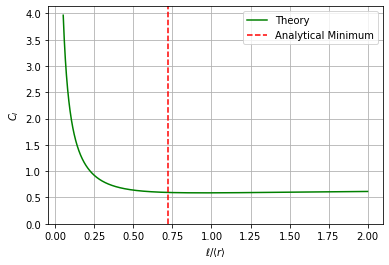

In [15]:
%matplotlib inline
fig, ax = plt.subplots()
xlabel = r"$\ell/\langle r\rangle$"

Ci_theory, Ci_theory_pt, Ci_theory_drt, _= \
    getCarbonIndexVectorized(ell_list, probabilityDist, eta, eps0, Q)

ax.plot(ell_list, Ci_theory, "-", c='green', label="Theory")
vline = ell_min_of_Q(Q)
if np.isreal(vline):
    ax.axvline(vline, ls='--', c='r', label="Analytical Minimum")
ax.set_ylabel(r"$C_I$")

ax.set_xlabel(xlabel)
ax.legend()
ax.grid()

ax.set_ylim((0,None))

# fig.savefig("CI22e-1QUniform.jpg", dpi=200)
plt.show()

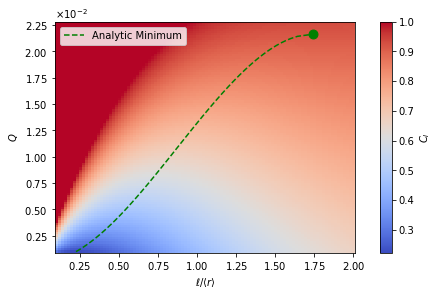

In [16]:
from matplotlib.colors import LogNorm, Normalize

fig, ax = plt.subplots(constrained_layout=True)

# mu_range = np.linspace(5,20,100)
# Q_range = Q_func(mu_range)
Q_range = np.linspace(0.001, float(Q_crit), 100)
Q_range2d = np.linspace(0.001, float(Q_crit)*1.05, 100)
ell_range = np.linspace(0.1,ell_max,100)
ELL, Q2D = np.meshgrid(ell_range, Q_range2d)

CI_THEORY,_,_,_ = getCarbonIndexVectorized(ELL, uniformDist, eta, eps0, Q2D)

# ax.plot_surface(ELL, MU, CI_THEORY, cmap='coolwarm')
min_ells = np.vectorize(ell_min_of_Q)(Q_range)
min_CIs,_,_,_ = getCarbonIndexVectorized(min_ells, uniformDist, eta, eps0, Q_range)

im = ax.pcolormesh(ELL, Q2D, CI_THEORY, cmap='coolwarm', shading='auto', vmax=1., zorder=0)
ax.plot(min_ells, Q_range, c='green', ls='--', label='Analytic Minimum', zorder=1)
ax.scatter(ell_min_of_Q(Q_crit), Q_crit, c='green', s=80, zorder=2)

ax.ticklabel_format(style="sci", scilimits=(0,0), useMathText=True)
ax.set_xlabel(r'$\ell/\langle r\rangle$')
ax.set_ylabel(r'$Q$')
fig.colorbar(im, label=r'$C_I$')

ax.legend()

# fig.savefig("CiOfMuAndQUniform.jpg", dpi=200)
plt.show()

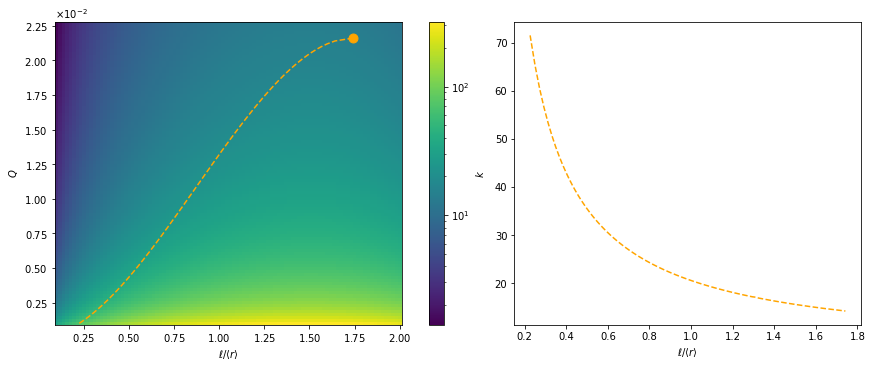

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5),constrained_layout=True)

Q_range = np.linspace(0.001, float(Q_crit), 100)
Q_range2d = np.linspace(0.001, float(Q_crit)*1.05, 100)
ell_range = np.linspace(0.1,ell_max,100)
ELL, Q2D = np.meshgrid(ell_range, Q_range2d)

capacity = getCapacityVectorized(ELL, uniformDist, Q2D, 2*beta*ELL)

im = ax1.pcolormesh(ELL, Q2D, capacity, shading='auto', norm=LogNorm())
ax1.plot(min_ells, Q_range, c='orange', ls='--', label='Analytic Minimum of C_I', zorder=1)
ax2.plot(min_ells, getCapacityVectorized(min_ells, uniformDist, Q_range, 2*beta*min_ells), c='orange', ls='--')
# ax2.plot(min_ells, min_CIs, c='orange', ls='--')
ax1.scatter(ell_min_of_Q(Q_crit), Q_crit, c='orange', s=80, zorder=2)

ax1.ticklabel_format(style="sci", scilimits=(0,0), useMathText=True)
ax1.set_xlabel(r'$\ell/\langle r\rangle$')
ax2.set_xlabel(r'$\ell/\langle r\rangle$')
ax1.set_ylabel(r'$Q$')
fig.colorbar(im, ax=ax1, label=r'$k$')

# fig.savefig("CiOfMuAndQUniform.jpg", dpi=200)
plt.show()

## Closer Look at Extrema

In [18]:
shift = (a/3).evalf(subs={s_beta: beta})
Qs = np.arange(0.001,0.04,0.001)
ell_min_unif0_list = np.empty(Qs.shape, dtype=np.complex128)
ell_min_unif1_list = np.empty(Qs.shape, dtype=np.complex128)
ell_min_unif2_list = np.empty(Qs.shape, dtype=np.complex128)

for i,Q in enumerate(Qs):
    ell_min_unif0_list[i] = ell_min_of_Q0_centered(Q) + shift
    ell_min_unif1_list[i] = ell_min_of_Q1_centered(Q) + shift
    ell_min_unif2_list[i] = ell_min_of_Q2_centered(Q) + shift

In [19]:
# def toMinimize(f, zeta, ell, eta, av_r, beta, Q, eps_0):
#     pt_prob,_ = scipy.integrate.quad(f,zeta*ell,np.infty)
#     return 1/(eta*av_r) * (zeta**2*ell*f(zeta*ell) + 2*beta*(pt_prob - ell*zeta*f(zeta*ell))) - 4*av_r/ell**2*Q*eps_0

def toMinimize(f, zeta, ell, eta, av_r, beta, Q, eps_0):
    pt_prob,_ = scipy.integrate.quad(f,zeta*ell,np.infty)
    return 1/(eta*av_r) * (2*beta*pt_prob) - 4*av_r/ell**2*Q*eps_0

def toMinimizeAnalytic(ell, eta, av_r, beta, Q, eps_0, k=3.1):
    return 2*beta/(eta*av_r)*scipy.special.gammainc(k-1, (k-2)/(2*beta*ell)) - 4*av_r*Q*eps_0/ell**2

# def toMinimizePrime(f, fprime, zeta, ell, eta, av_r, beta, Q, eps_0):
#     pt_prob,_ = scipy.integrate.quad(f,zeta*ell,np.infty)
#     return 1/(eta*av_r) * (zeta*f(zeta*ell)*(zeta-4*beta) + zeta**2*ell*fprime(zeta*ell)*(zeta-2*beta)) + 8*av_r/ell**3*Q*eps_0

def toMinimizePrime(f, ell, eta, av_r, beta, Q, eps_0):
    return -4*beta**2/(eta*av_r) * f(zeta*ell) + 8*av_r/ell**3*Q*eps_0

toMinimizeOfQEllAnalitic = lambda ell, Q: toMinimizeAnalytic(ell, eta, mean_distance, beta, Q, eps0)
toMinimizeOfQEll = lambda ell, Q: toMinimize(inverseGammaDist, zeta, ell, eta, mean_distance, beta, Q, eps0)
toMinimizeOfQEllPrime = lambda ell, Q: toMinimizePrime(inverseGammaDist, ell, eta, mean_distance, beta, Q, eps0)

Qs_uniform = np.linspace(0.0001,0.021,200)
ell_min_uniform_list = np.vectorize(ell_min_of_Q0_centered)(Qs_uniform) + shift
# ell_min_inv_gamma_list = [scipy.optimize.newton(toMinimizeOfQEllAnalitic, x0=float(ell_min_uniform_list[i]), args=(Q,), fprime=toMinimizeOfQEllPrime) for i,Q in enumerate(Qs_inv_gamma)]
ell_min_inv_gamma_list = np.empty_like(Qs_uniform)
for i,Q in enumerate(Qs_uniform):
    try:
        ell_min_inv_gamma_list[i] = scipy.optimize.newton(toMinimizeOfQEllAnalitic, x0=float(ell_min_uniform_list[i]), args=(Q,), fprime=toMinimizeOfQEllPrime)
    except RuntimeError:
        print("Cutting list of values at {}, because minimization did not converge".format(i))
        ell_min_inv_gamma_list = ell_min_inv_gamma_list[:i]
        Qs_inv_gamma = Qs_uniform[:i]
        break

Cutting list of values at 143, because minimization did not converge


In [20]:
%matplotlib inline
probabilityDist = inverseGammaDist
deprCubicFunc = sympy.lambdify([s_ell, s_Q, s_eps0, s_eta, s_beta], depressed_cubic_eq)
discrFunc = sympy.lambdify([s_Q, s_eps0, s_eta, s_beta], discriminant)
hessian_llFunc = sympy.lambdify([s_ell, s_Q, s_beta, s_eta, s_eps0], hessian_ll)
hessian_zzFunc = sympy.lambdify([s_ell, s_eta], hessian_zz)

ells = np.linspace(-2,2,200)
pos_ells = np.linspace(0.1,2+float(shift),100)

def plotDeprCubic(i):
    Q = Qs[i]
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12.8,4.8))
    
    ax1.plot(ells+shift, deprCubicFunc(ells, Q, eps0, eta, beta))
    Ci_theory,Ci_pt,Ci_drt,_ = \
        getCarbonIndexVectorized(pos_ells, probabilityDist, eta, eps0, Q)
    ax2.plot(pos_ells, Ci_theory, "-", c='green', label="Theory")
    ylims = ax1.get_ylim()
    ax1.grid()
    ax2.grid()
    ax1.set_xlabel(r"$\ell/\langle r\rangle$")
    ax2.set_xlabel(r"$\ell/\langle r\rangle$")
    ax2.set_ylabel(r"$C_I$")
    
    ax1.scatter(0, discrFunc(Q, eps0, eta, beta))
    ax1.axhline(0, c='black')
    ell_min_unif0 = np.real_if_close(ell_min_unif0_list[i])
    ell_min_unif1 = np.real_if_close(ell_min_unif1_list[i])
    ell_min_unif2 = np.real_if_close(ell_min_unif2_list[i])
    if Q <= Qs_inv_gamma[-1]:
        ell_min_infGamma = ell_min_inv_gamma_list[np.abs(Qs_inv_gamma - Q).argmin()]
        ax2.axvline(ell_min_infGamma, ls='--', c='yellow')
    if np.isreal(ell_min_unif0):
        ax2.axvline(ell_min_unif0, ls='--', c='orange')
        ax1.axvline(ell_min_unif0, ls='--', c='orange')
        ax1.scatter(ell_min_unif0, hessian_llFunc(ell_min_unif0, Q, beta, eta, eps0), c='orange')
        ax1.scatter(ell_min_unif0, hessian_zzFunc(ell_min_unif0, eta), c='orange')
    if np.isreal(ell_min_unif1):
        ax1.axvline(ell_min_unif1, ls='--', c='violet')
#         ax2.axvline(ell_min_unif1, ls='--', c='violet')
        ax1.scatter(ell_min_unif1, hessian_llFunc(ell_min_unif1, Q, beta, eta, eps0), c='violet')
        ax1.scatter(ell_min_unif1, hessian_zzFunc(ell_min_unif1, eta), c='violet')
#         display(ell_min_unif1+shift)
    if np.isreal(ell_min_unif2):
        ax1.axvline(ell_min_unif2, ls='--', c='green')
#         ax2.axvline(ell_min_unif2, ls='--', c='green')
        ax1.scatter(ell_min_unif2, hessian_llFunc(ell_min_unif2, Q, beta, eta, eps0), c='green')
        ax1.scatter(ell_min_unif2, hessian_zzFunc(ell_min_unif2, eta), c='green')
    ax1.set_ylim(ylims)
    ax2.set_xlim(0, pos_ells[-1])
    if Q < Q_crit:
        fig.suptitle("Q = {} < Q_crit".format(round(Q,3)))
    else:
        fig.suptitle("Q = {} > Q_crit".format(round(Q,3)))
    plt.show()

# print("To get values of minima all values have to be shifted by +", round(shift,3))
print("Left: The dot is the discriminant of the cubic eq, the blue function is the cubic eq, vlines are zeros of cubic eq, and dots on these lines are the corresponding eigenvalues of hessian")
print("Right: Carbon Index")
interact(plotDeprCubic, i=IntSlider(min=0,max=len(Qs)-1,step=1));

Left: The dot is the discriminant of the cubic eq, the blue function is the cubic eq, vlines are zeros of cubic eq, and dots on these lines are the corresponding eigenvalues of hessian
Right: Carbon Index


interactive(children=(IntSlider(value=0, description='i', max=38), Output()), _dom_classes=('widget-interact',…

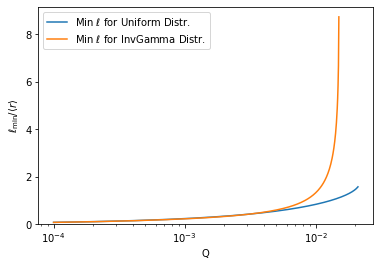

In [21]:
fig, ax = plt.subplots()

idx = np.s_[:]

Qs_uniform_plot = Qs_uniform[idx]
ell_min_uniform_list_plot = ell_min_uniform_list[idx]
Qs_inv_gamma_plot = Qs_inv_gamma[idx]
ell_min_inv_gamma_list_plot = ell_min_inv_gamma_list[idx]

ax.plot(Qs_uniform_plot, ell_min_uniform_list_plot, label="Min "+r"$\ell$"+" for Uniform Distr.")
ax.plot(Qs_inv_gamma_plot, ell_min_inv_gamma_list_plot, label="Min "+r"$\ell$"+" for InvGamma Distr.")
ax.set_ylim(0,None)
ax.set_ylabel(r"$\ell_\mathrm{min} / \langle r\rangle$")
ax.set_xlabel("Q")
ax.set_xscale('log')

ax.legend()

# fig.savefig("MinEllOfHigherQLog.jpg", dpi=200)
plt.show()

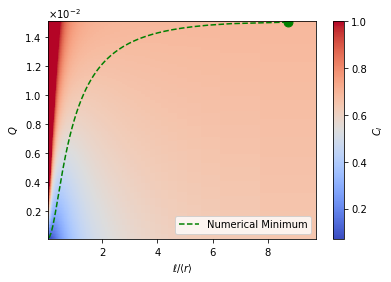

In [22]:
from matplotlib.colors import LogNorm, Normalize

fig, ax = plt.subplots()

ELL, Q2D = np.meshgrid(ell_min_inv_gamma_list, Qs_inv_gamma)

CI_THEORY,_,_,_ = getCarbonIndexVectorized(ELL, probabilityDist, eta, eps0, Q2D)

min_CIs,_,_,_ = getCarbonIndexVectorized(min_ells, probabilityDist, eta, eps0, Q_range)

im = ax.pcolormesh(ELL, Q2D, CI_THEORY, cmap='coolwarm', shading='auto', vmax=1, zorder=0)
ax.plot(ell_min_inv_gamma_list, Qs_inv_gamma[:len(ell_min_inv_gamma_list)], c='green', ls='--', label='Numerical Minimum', zorder=1)
ax.scatter(ell_min_inv_gamma_list[-1], Qs_inv_gamma[:len(ell_min_inv_gamma_list)][-1], c='green', s=80, zorder=2)

ax.ticklabel_format(style="sci", scilimits=(0,0), useMathText=True)
ax.set_xlabel(r'$\ell/\langle r\rangle$')
ax.set_ylabel(r'$Q$')
fig.colorbar(im, label=r'$C_I$')

ax.legend(loc='lower right')

# fig.savefig("CiOfMuAndQInvGamma.jpg", dpi=200)
plt.show()

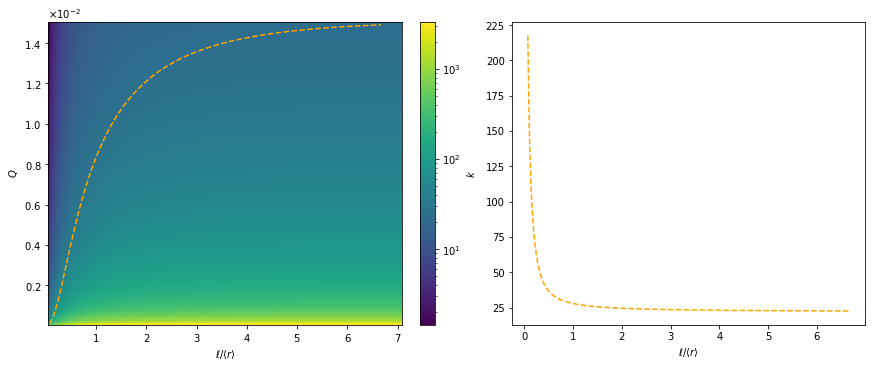

In [23]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5),constrained_layout=True)

capacity = getCapacityVectorized(ELL, probabilityDist, Q2D, 2*beta*ELL)
to_idx = (np.nonzero(capacity>0)[1]).max()

im = ax1.pcolormesh(ELL[:,:to_idx], Q2D[:,:to_idx], capacity[:,:to_idx], shading='auto', norm=LogNorm())
# im = ax1.pcolormesh(ELL[:,:to_idx], Q2D[:,:to_idx], CI_THEORY[:,:to_idx], shading='auto', cmap="coolwarm", vmax=1)
ax1.plot(ell_min_inv_gamma_list[:to_idx], Qs_inv_gamma[:len(ell_min_inv_gamma_list)][:to_idx], c='orange', ls='--', label='Numerical Minimum of C_I', zorder=1)
ax2.plot(ell_min_inv_gamma_list[:to_idx], getCapacityVectorized(ell_min_inv_gamma_list, probabilityDist, Qs_inv_gamma, 2*beta*ell_min_inv_gamma_list)[:to_idx], c='orange', ls='--')
# ax2.plot(ell_min_inv_gamma_list[:to_idx], min_CIs[:to_idx], c='orange', ls='--')
# ax1.scatter(ell_min_inv_gamma_list[-1], Qs_inv_gamma[:len(ell_min_inv_gamma_list)][-1], c='green', s=80, zorder=2)

ax1.ticklabel_format(style="sci", scilimits=(0,0), useMathText=True)
ax1.set_xlabel(r'$\ell/\langle r\rangle$')
ax2.set_xlabel(r'$\ell/\langle r\rangle$')
ax1.set_ylabel(r'$Q$')
fig.colorbar(im, ax=ax1, label=r'$k$')

# fig.savefig("CiOfMuAndQUniform.jpg", dpi=200)
plt.show()

---
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# $C_I$ in Combination with supply-demand

In [24]:
# def delta_av_theory(delta_max, b, mode='mft'):
#     delta_max = 1.5
#     delta_bar = 2 * delta_max / 3 + 1 / (3 * delta_max)
#     if mode=='mft':
#         return np.exp(np.log(delta_bar) / np.log(2) * np.log((2*b - 1)))
#     elif mode=='bimodal_test':
#         return np.exp(np.log(delta_bar) / np.log(2) * np.log((b + 1) / 2))


# def getCarbonIndex(ell, p, eta, eps0p, Q):
#     zeta = 2*beta/(1-4*eta*eps0p/np.pi)
# #     print("Zeta: ", zeta)
#     rpr = lambda r : r*p(r) # r*p(r)
#     cummulative_prob = lambda x: scipy.integrate.quad(p,0,x)[0]

#     av_d = scipy.integrate.quad(rpr,0,np.infty)[0]
#     Ci_drt = 1/eta*(scipy.integrate.quad(rpr,0,zeta*ell)[0] + 2*beta*ell*(1-cummulative_prob(zeta*ell)))/av_d
#     Ci_pt = 4*eps0p/(np.pi*av_d)*scipy.integrate.quad(rpr, zeta*ell, np.infty)[0]

#     Ci = Ci_drt + Ci_pt

#     return Ci, Ci_pt, Ci_drt, av_d


# getCarbonIndexVectorized = np.vectorize(getCarbonIndex)

# delta_av_theory = delta_av_theory(1.5, 2, mode='mft')

# av_drt_occs_non_standing = 2
# eta = av_drt_occs_non_standing/delta_av_theory

In [25]:
# Ci_theory, Ci_theory_pt, Ci_theory_drt,_ = \
#     getCarbonIndexVectorized(ell_list, uniformDist, eta, 0.1*np.pi/(4*eta), Q)

# fig, ax = plt.subplots()
# ax.plot(ell_list, Ci_theory, "-", c='green', label="Theory")

# ax.set_ylabel(r"$C_I$")
# ax.set_xlabel(xlabel)
# ax.legend()
# ax.grid()

# ax.set_ylim((0,None))

# plt.show()